# Imports

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
import numpy as np
import pandas
import timeit #more accurate than time

# import theano
import tensorflow

from sklearn.decomposition import PCA
# from sklearn.externals import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential, model_from_json, load_model, clone_model
# from keras.optimizers import SGD
# from keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import FalsePositives, FalseNegatives

from sklearn.utils import shuffle

from six.moves import cPickle #Faster than pickle


## Neural Nets functions

In [2]:
def getDistribuitionFitter(model, compileArgs):
    classModel = Sequential()
    depth = None
    width = None
    step = None
    fit_func = 'sigmoid' 
    layerSizes = []

    if model == "model1":   # for an approximately linear fit
        layerSizes = [20, 4, 5]
    elif model == "model0":
        layerSizes = [10, 5]        
    
    for i,width in enumerate(layerSizes):
        if i==0:
            classModel.add(Dense(width, input_shape=(1,), kernel_initializer='normal', activation=fit_func))
        else:
            classModel.add(Dense(width, kernel_initializer='normal', activation=fit_func))
    
    classModel.add(Dense(1, kernel_initializer='normal'))

    classModel.compile(**compileArgs)

    return classModel
  

In [3]:
def getClassifier(inputs, outputs, model, compileArgs):
    classModel = Sequential()

    layerSizes = []
    if model == "model0":
        width = 50
        depth = 5
        step = 5
        for i in range(depth):
            if i==0:
                layerSizes.append(width)
            else:
                layerSizes.append(layerSizes[-1]-step)
    
    for i, width in enumerate(layerSizes):
        if i==0:
            classModel.add(Dense(width, input_shape=(inputs, ), kernel_initializer='normal', activation='relu'))
        else:
            classModel.add(Dropout(0.05)) # play around with this
            classModel.add(Dense(width, kernel_initializer='normal', activation='relu'))

    classModel.add(Dense(outputs, kernel_initializer='normal', activation='sigmoid'))
    
    classModel.compile(**compileArgs)

    return classModel
    

## Callbacks

In [4]:
class LossHistory(Callback):
    def __init__(self, trData):
        self.trainingData = trData
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))
        

In [5]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
    

## Distribution Fit Definition

In [6]:

class DistribuitionFit:

    # default parameters
    compileArgs = {'loss':'mean_squared_error', 
              'optimizer':'Adam'}
    
    trainParams     = {'epochs' : 3000, 
                   'batch_size' : 30, 
                      'verbose' : 2}

    netModel = None
    norm_const = 1
    x_train = None
    y_train = None
    xrange = (-1, 1)
    has_train = False
    h = 1.0e-3 # this value can change with Ntot and dataRange
    def __init__(self, compileArgs={}, trainParams={}, modelID='model1', weights=None, baseModel=None):
        for args in compileArgs:
            self.compileArgs[args] = compileArgs[args] 

        for params in trainParams:
            self.trainParams[params] = trainParams[params]

        if not baseModel:
            self.netModel = getDistribuitionFitter(modelID, self.compileArgs)
        else:
            self.netModel = clone_model(baseModel)
        
        if weights:
            self.netModel.set_weights(weights)
        
        # self.netModel.summary()

    def count(sortedData, x):
        for i in range(len(sortedData)):
            if x < sortedData[i]:
                return (i+0.)/(len(sortedData))
        return 1

    def train(self, data, xrange=None, h=None, trainParams=None ,verbose=0, xrange_excess=0, density=50, edge_density_mult=1, do_train=True): 
        # data:  raw, unsorted random data from some distribuition
        # xrange: range to fit
        # xrange_excess: extra range from the borders in percentage of total range
        # edge_fix: how much does the density increases at the excess zone
        data.sort()
        self.data = np.array(data)

        if not xrange:
            xrange = (data[0], data[-1])

        self.xrange0 = xrange

        xdelta_excess = (xrange[1]-xrange[0])*xrange_excess/2
        xdelta = (xrange[1]-xrange[0])/2 + xdelta_excess
        xcenter = (xrange[1]+xrange[0])/2
        self.xrange = (xcenter-xdelta, xcenter+xdelta)
       
        # the lower this value the more oscillations there are on the derivative
        if h == None:
            self.h = (self.xrange[1]-self.xrange[0])*1.0e-5
        else:
            self.h = h

        if not trainParams:
            trainParams = self.trainParams

        if do_train: # in case one only wants to initialise the data 
            N = len(data)

            arr = np.array([])
            # arr = np.append(arr, self.xrange[0]-xdelta_excess, self.xrange[0], 
            #                       edge_density_mult*xrange_excess*N))
            arr = np.append(arr, np.linspace(xrange[0]-xdelta_excess, xrange[0],
                                            int(N*density*edge_density_mult*xrange_excess)))
            arr = np.append(arr, np.linspace(*xrange, int(N*density)))
            arr = np.append(arr, np.linspace(xrange[1], xrange[1]+xdelta_excess, 
                                            int(N*density*edge_density_mult*xrange_excess)))

            self.x_train = np.unique(arr)

            self.y_train = np.array([DistribuitionFit.count(data, x) for x in self.x_train])

            lossHistory = LossHistory( (self.x_train, self.y_train))
            earlyStop = EarlyStopping(monitor="loss", patience=3, verbose=0, mode="auto")

            # print(len(self.x_train), len(self.y_train))
        
            c = self.netModel.fit(self.x_train, self.y_train, **trainParams, callbacks=[lossHistory, earlyStop])
            self.has_train=True
            if verbose==2:
                self.plotIntegratedComparison()

            return c 

    def normalise(self, dx=0, h=0):
        if dx==0: dx = self.h*10
        # print(*self.xrange, (self.xrange[1]-self.xrange[0])/dx)
        
        xval = np.linspace(*self.xrange, int((self.xrange[1]-self.xrange[0])/dx))
 
        self.norm_const = np.sum(self.probability_array(xval, h))*dx 

    def probability(self, x, h=0):
        if h==0: h = self.h 
        if x <= self.xrange0[0] or x >= self.xrange0[1]: # if its outside of range
            return 0
        p1, p0 = self.netModel.predict((x+h, x-h))
        val = (p1[0]-p0[0])/(2*h*self.norm_const)
        if val>0:
            return val
        else:
            return 0

    def probability_array(self, xarray, h=0):
        if h==0: h = self.h 

        arr_plus = np.array([v[0] for v in self.netModel.predict([x+h for x in xarray ])])
        arr_minus= np.array([v[0] for v in self.netModel.predict([x-h for x in xarray ])])

        temp = []
        for i,x in enumerate(xarray):
            if x <= self.xrange0[0] or x >= self.xrange0[1]:# if its outside of range
                temp.append(0)
            else:
                val = (arr_plus[i]-arr_minus[i])/(2*h*self.norm_const)
                if val<0:
                    temp.append(0)
                else:
                    temp.append(val)

        return np.array(temp)

    def plotIntegratedComparison(self):
        # plots the integrated histogram and its fit (direct output from fit)

        # plt.plot(x_train_data, y_train_data)
        if not self.has_train or not self.netModel:
            print(" Model hasn't yet trained! No data!")
            return
        xval = np.linspace(*self.xrange, 400)
        y_test = self.netModel.predict(xval)

        plt.plot(xval, y_test)
        plt.plot(self.x_train, self.y_train)

    def plotHist(self, xrange=(), histparams={}):
        # plots the data histogram
        if not xrange:
            xrange = self.xrange
        ax = sns.distplot(self.data, norm_hist = True, kde=False, **histparams)
        # plt.hist(self.csv_file[self.features[k]] , **params)
        if range:
            ax.set_xlim(*xrange)
        else:
            ax.set_xlim(*xrange)
        # plt.legend()
    
    def plotDistribuition(self, xrange=(), histparams={}, nPoints=200):
        # plots the probability values
        if not xrange:
            xrange = self.xrange
        xval = np.linspace(*xrange, nPoints)
        plt.plot(xval, self.probability_array(xval))
        
        

## MultiFeature fit class

In [7]:
# default ranges: (-1, 1) for all except: Impact Parameter -> (-1, 10)


class MultiFeature :
    
    # default parameters = {}
    compileArgs = {'loss':'mean_squared_error', 
            'optimizer':'Adam'}
        
    trainParams = {'epochs' : 100,
                'batch_size' : 50, 
                    'verbose' : 2}

    trainParams_getfile = {'epochs' : 1,
                'batch_size' : 50, 
                    'verbose' : 0}

    fitParams_getfile = {'verbose':2, 
                    'xrange_excess': 0.2,
                    'density': 0,
                    'edge_density_mult':3}

    distfit_array = None
    features = []
    csv_file = None
    dev_data = None
    val_data = None

    def __init__(self, csv_file, features, parameters={}, xrange=None):
        # features: list of strings
        self.csv_file = csv_file
        self.features = features 
        trainParams = {}
        compileArgs = {}

        self.dev_data = {}
        self.val_data = {}
        self.distfit_array = {}

        if 'trainParams' in parameters:
            for pars in parameters['trainParams']:
                if pars in parameters['trainParams']:
                    self.trainParams[pars] = parameters['trainParams'][pars]
        
        if 'compileArgs' in parameters:
            for args in parameters['compileArgs']:
                if args in parameters['compileArgs']:
                    self.compileArgs[args] = parameters['compileArgs'][args]
        
        

        # self.distfit = DistribuitionFit(trainParams=self.trainParams, compileArgs=self.compileArgs)
        for k, feat in enumerate(features):
            param_model = "model_{}".format(k)
            if param_model in parameters:
                self.distfit_array[feat] = DistribuitionFit(trainParams=self.trainParams, 
                                                            compileArgs=self.compileArgs, modelID=parameters[param_model])
            else:
                self.distfit_array[feat] = DistribuitionFit(trainParams=self.trainParams, 
                                                            compileArgs=self.compileArgs)
            # a,b = train_test_split(self.csv_file[feat], test_size=split)
            self.dev_data[feat] = self.csv_file[feat]
            # self.val_data[feat] = b
            # print(feat, len(self.dev_data[feat]), len(self.val_data[feat]))
        
        if xrange:
            self.normalise_ranges(xrange)

    def fitFeature(self, k, fitParams={}, trainParams=None):
        feat = self.features[k]
        if not trainParams:
            trainParams = self.trainParams
        self.distfit_array[feat].train(self.dev_data[feat].to_numpy(), **fitParams, trainParams=trainParams)
        self.distfit_array[feat].normalise()
        
        print(k, ' Finished fitting ', feat)
        
    # def resetFit(self,k, modelID=None):
    #     feat = self.features[k]
    #     if not modelID:
    #         self.distfit_array[feat] = DistribuitionFit(self.compileArgs, self.trainParams)
    #     else:
    #         self.distfit_array[feat] = DistribuitionFit(self.compileArgs, self.trainParams, modelID)

    def normalise_ranges(self, xrange=(-1, 1)):
        # normalise dev_data and val_data
        x_delta = xrange[1]-xrange[0]
        for feat in self.features:
            dev_max = np.max(self.dev_data[feat])
            dev_min = np.min(self.dev_data[feat])
            
            dev_delta = dev_max - dev_min
            
            self.dev_data[feat] = (self.dev_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
            # self.val_data[feat] = (self.val_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
    
    def normalise_range(self, k, xrange=(-1, 1)):
        # normalise dev_data and val_data
        feat = self.features[k]
        x_delta = xrange[1]-xrange[0]
        
        dev_max = np.max(self.dev_data[feat])
        dev_min = np.min(self.dev_data[feat])
        
        dev_delta = dev_max - dev_min
        
        self.dev_data[feat] = (self.dev_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
        # self.val_data[feat] = (self.val_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
    
    def save_distribuitions_to_file(self, dirname):
        if not os.path.isdir(dirname):
            os.makedirs(dirname)
        for feat in self.features:
            filename = "{}\\feature-{}.h5".format(dirname, feat.replace("/", "_"))
            self.distfit_array[feat].netModel.save(filename)
    
    def get_distribuitions_from_file(self, dirname, verbose=0):
        # make sure to set the ranges to the right values
        for k,feat in enumerate(self.features):
            if verbose==1:
                print("Loading model ", feat)
            filename = "{}\\feature-{}.h5".format(dirname, feat.replace("/", "_"))
            if not os.path.exists(filename):
                print("weight file ", filename, " doesn't exist")
            self.distfit_array[feat].netModel = load_model(filename, compile = False)
            self.fitFeature(k, {'do_train':False})
            self.distfit_array[feat].normalise()

    def drawFeatureHist(self, k, params={}, xrange=()):
        self.distfit_array[self.features[k]].plotHist(xrange, params)
        
    # def fitAll(self, fitParams, trainParams=None):
    #     if trainParams:
    #         for k,feat in enumerate(self.features):
    #             self.fitFeature(k, fitParams, trainParams=trainParams)
    #             if 'verbose' in fitParams and fitParams['verbose']==2:
    #                 plt.show()
    #     else:
    #         for k,feat in enumerate(self.features):
    #             self.fitFeature(k, fitParams)
    #             if 'verbose' in fitParams and fitParams['verbose']==2:
    #                 plt.show()

    def drawDistComparison(self, k, params={}, xrange=()):
        # compares the distribuition (probability) to the histogram
        self.drawFeatureHist(k, params, xrange)
        self.distfit_array[self.features[k]].plotDistribuition(xrange, params)


# Select decay

In [8]:
# Decays ->  [1] ('pi pi', 'pi mu') [2] ('K mu', 'mu mu')

# susy = 1, 2
# decay = [susy=1] ('pi pi', 'pi mu') [susy=2] ('K mu', 'mu mu')
# Nmass = 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 'All'
decay_select = { 'susy':2, 
                'decay':'K mu', 
                'Nmass':'All'}

# Loading signal and background files

In [9]:
os.chdir("C:\\Users\\raulf\\Documents\\Neutralinos\\")

In [10]:
os.chdir("C:\\Users\\raulf\\Documents\\Neutralinos\\")

all_signal_ID = {}

for Nmass in [0.6,0.8,1.0,1.2,1.4,1.6]:
    all_signal_ID[Nmass] = {}
    
    all_signal_ID[Nmass][1] = {}
    all_signal_ID[Nmass][1]['pi pi'] = ("pi- pi+ ",)
    all_signal_ID[Nmass][1]['pi mu'] = ("pi- mu+ ", "mu- pi+ ")

    all_signal_ID[Nmass][2] = {}
    all_signal_ID[Nmass][2]['K mu'] = ("K- mu+ ", "mu- K+ ")
    all_signal_ID[Nmass][2]['mu mu'] =("mu+ mu- ",)

signal_files = []
background_files = []

background_types = ['e', 'e_bar', 'mu', 'mu_bar']

if decay_select['Nmass'] == 'All':
    for nmass in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
        susy = decay_select['susy']
        decay_type = decay_select['decay']
        for dec in all_signal_ID[ nmass ][ susy ][ decay_type ]:
            signal_files.append("ShipAnalysis/NeutralinoDecayData/decay3/SfMass=1000/N0Mass={0}/susyBench{1}/kinematic_variables_{2}.dat".format(nmass, susy, dec))
            for backtype in background_types:
                background_files.append("SHiP-Data/Raul/{0}/kinematic_variables_{1}.dat".format(backtype, dec))
else:
    nmass = decay_select['Nmass']
    susy = decay_select['susy']
    decay_type = decay_select['decay']
    for dec in all_signal_ID[ nmass ][ susy ][ decay_type ]:
        signal_files.append("ShipAnalysis/NeutralinoDecayData/decay3/SfMass=1000/N0Mass={0}/susyBench{1}/kinematic_variables_{2}.dat".format(nmass, susy, dec))
        for backtype in background_types:
                background_files.append("SHiP-Data/Raul/{0}/kinematic_variables_{1}.dat".format(backtype, dec))

def read_csvs_and_concat(filename_list):
    file_list = []
    filename_list = np.unique(filename_list)
    for filename in filename_list:
        file_list.append(pandas.read_csv(filename))
    
    return pandas.concat(file_list)

FullSignal_file = read_csvs_and_concat(signal_files)
FullBackground_file = read_csvs_and_concat(background_files)

print(len(FullSignal_file))
print(len(FullBackground_file))



all_features = {}
for i,name in enumerate(FullSignal_file.columns):
    all_features[i] = name
print(all_features)

selected_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14]

feature_names = [all_features[i] for i in selected_features]

# print(len(mf_signal.dev_data[feature_names[0]]), len(mf_background.dev_data[feature_names[0]]))

3539
92
{0: 'Mother Total Momentum (GeV/c)', 1: ' Mother Transverse Momentum (GeV/c)', 2: ' Mother Fraction of Transverse Momentum', 3: ' Opening Angle (rad)', 4: ' Decay Angle (rad)', 5: ' Impact Parameter (cm)', 6: ' Daughter1 Total Momentum (GeV/c)', 7: ' Daughter1 Transverse Momentum (GeV/c)', 8: ' Daughter1 Fraction of Transverse Momentum', 9: ' Daughter2 Total Momentum (GeV/c)', 10: ' Daughter2 Transverse Momentum (GeV/c)', 11: ' Daughter2 Fraction of Transverse Momentum', 12: ' Decay Z (cm)', 13: ' Decay X (cm)', 14: ' Decay Y (cm)', 15: ' Event type'}


# Analysis of probability results on validation data

In [15]:
# defaults
compileArgs = {'loss':'mean_squared_error', 
          'optimizer':'Adam'}
    
trainParams = {'epochs' : 1,
            'batch_size' : 10, 
                'verbose' : 2}

In [12]:
# decay = [susy=1] ('pi pi', 'pi mu') [susy=2] ('K mu', 'mu mu')
decay_analysis = decay_select['decay']

dirname = "Network Saves\\"
filename_signal = "{}\\signal-1-{}\\".format(dirname, decay_analysis)
filename_background = "{}\\background-1-{}\\".format(dirname, decay_analysis)

selected_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14]
feature_names = [all_features[i] for i in selected_features]

# load the distribuitions from memory
mf_signal = MultiFeature(FullSignal_file, feature_names, parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange=(-1, 1))
mf_signal.normalise_range(4, (-1,10))
mf_signal.get_distribuitions_from_file(filename_signal)

mf_background = MultiFeature(FullBackground_file, feature_names, parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange=(-1, 1))
mf_background.normalise_range(4, (-1,10))
mf_background.get_distribuitions_from_file(filename_background)


0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   Daughter1 Total Momentum (GeV/c)
6  Finished fitting   Daughter1 Transverse Momentum (GeV/c)
7  Finished fitting   Daughter1 Fraction of Transverse Momentum
8  Finished fitting   Daughter2 Total Momentum (GeV/c)
9  Finished fitting   Daughter2 Transverse Momentum (GeV/c)
10  Finished fitting   Daughter2 Fraction of Transverse Momentum
11  Finished fitting   Decay Z (cm)
12  Finished fitting   Decay X (cm)
13  Finished fitting   Decay Y (cm)
0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   D

In [14]:
mf_signal.
for k, feat in enumerate(feature_names):
    mf_signal.distfit_array[feat].normalise()
    mf_signal.distfit_array[feat].plotIntegratedComparison()

 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!
 Model hasn't yet trained! No data!


Assuring the fits are well done

0 Mother Total Momentum (GeV/c)


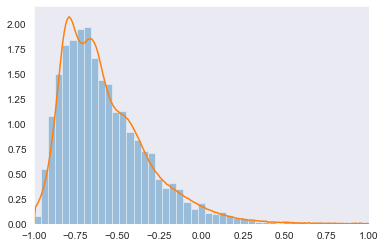

1  Mother Transverse Momentum (GeV/c)


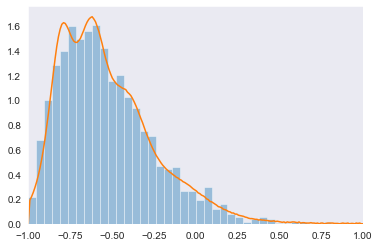

2  Mother Fraction of Transverse Momentum


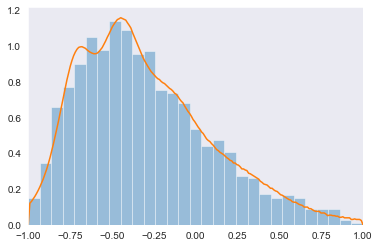

3  Opening Angle (rad)


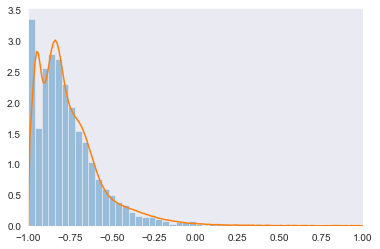

4  Impact Parameter (cm)


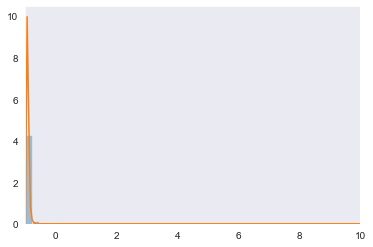

5  Daughter1 Total Momentum (GeV/c)


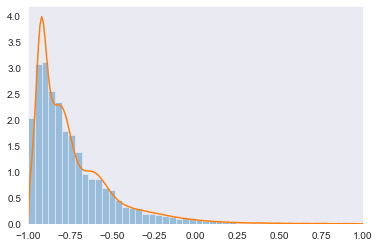

6  Daughter1 Transverse Momentum (GeV/c)


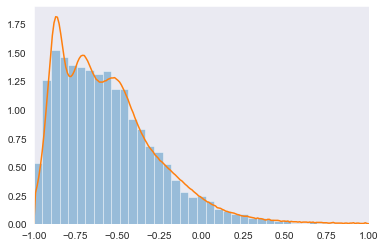

7  Daughter1 Fraction of Transverse Momentum


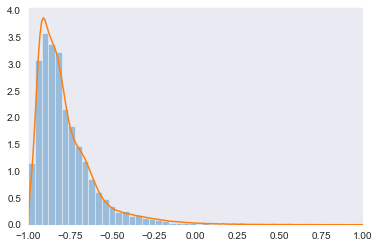

8  Daughter2 Total Momentum (GeV/c)


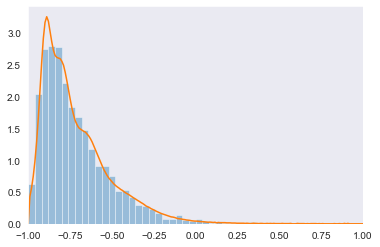

9  Daughter2 Transverse Momentum (GeV/c)


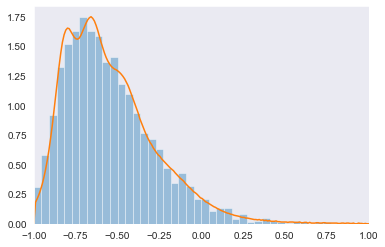

10  Daughter2 Fraction of Transverse Momentum


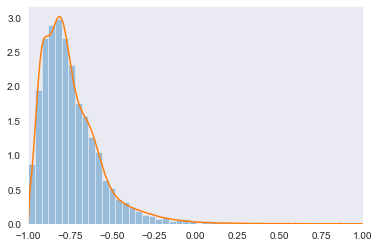

11  Decay Z (cm)


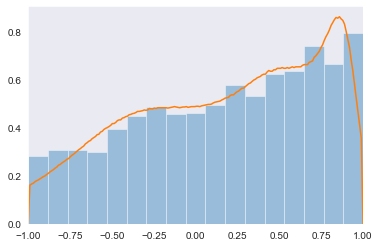

12  Decay X (cm)


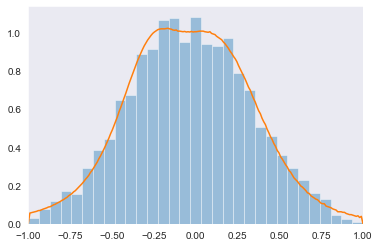

13  Decay Y (cm)


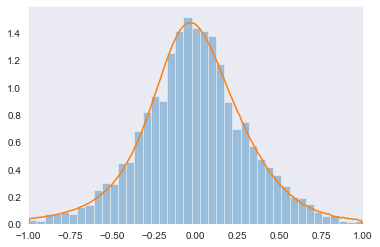

0 Mother Total Momentum (GeV/c)


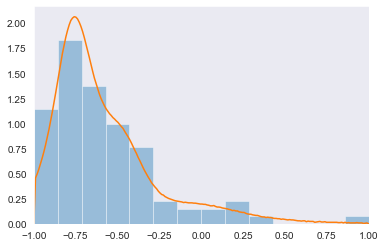

1  Mother Transverse Momentum (GeV/c)


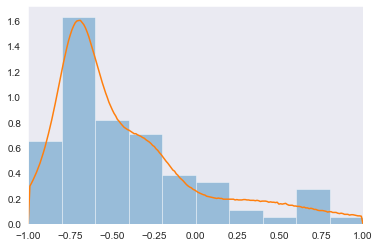

2  Mother Fraction of Transverse Momentum


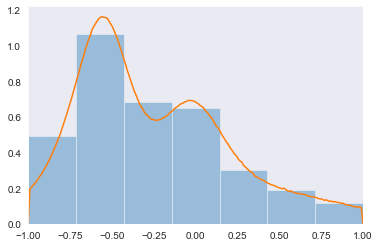

3  Opening Angle (rad)


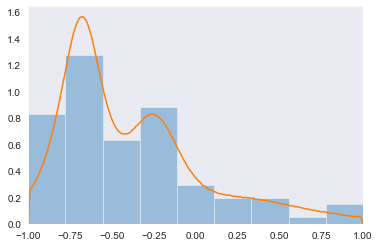

4  Impact Parameter (cm)


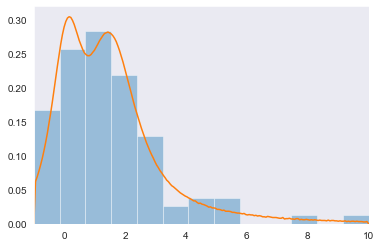

5  Daughter1 Total Momentum (GeV/c)


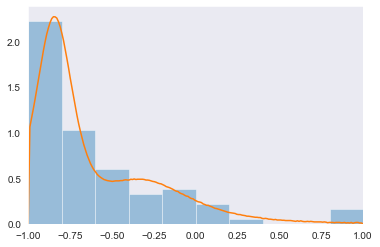

6  Daughter1 Transverse Momentum (GeV/c)


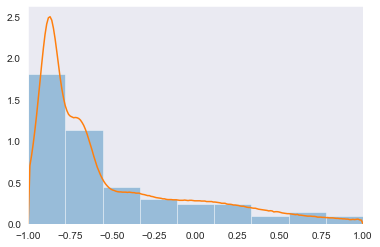

7  Daughter1 Fraction of Transverse Momentum


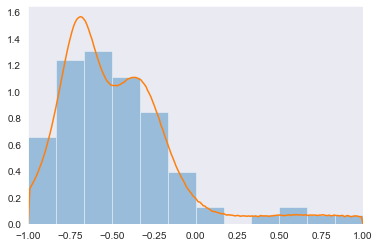

8  Daughter2 Total Momentum (GeV/c)


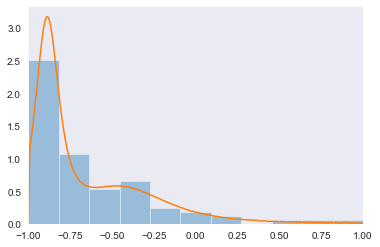

9  Daughter2 Transverse Momentum (GeV/c)


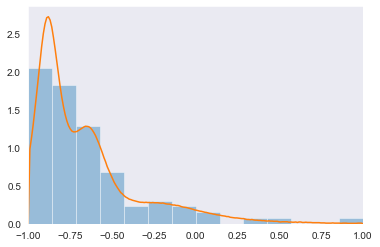

10  Daughter2 Fraction of Transverse Momentum


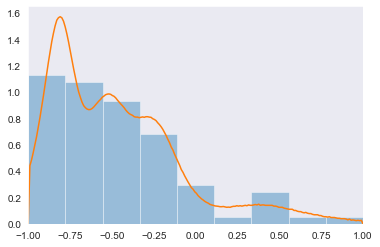

11  Decay Z (cm)


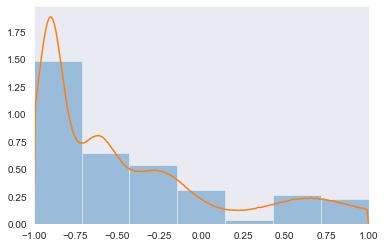

12  Decay X (cm)


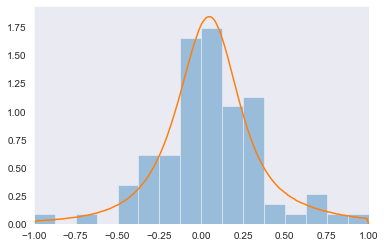

13  Decay Y (cm)


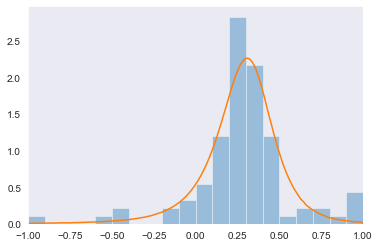

In [13]:
for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_signal.distfit_array[feat].normalise()
    # print(mf_signal.distfit_array[feat].norm_const)
    mf_signal.drawDistComparison(k)
    
    plt.show()

for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_background.drawDistComparison(k)
    plt.show()

## Some boxplots

In [75]:
feature_size = len(mf_signal.features)

# validation data includes the probability dev data

val_signal_size = len(mf_signal.dev_data[feature_names[0]]) 
val_background_size = len(mf_background.dev_data[feature_names[0]])

validation_size = np.min((val_signal_size, val_background_size))
print(validation_size)

signal_select = np.random.choice(range(val_signal_size), validation_size, replace=False)
background_select = np.random.choice(range(val_background_size), validation_size, replace=False)

signal_data = []
background_data = []
validation_data = []

for i in signal_select:
    temp = np.empty(feature_size+1)

    for k, feat in enumerate(mf_signal.dev_data):
        temp[k] = mf_signal.dev_data[feat].iat[i]
    temp[-1]=1
    signal_data.append(temp)
    validation_data.append(temp)

for i in background_select:
    temp = np.empty(feature_size+1)

    for k, feat in enumerate(mf_background.dev_data):
        temp[k] = mf_background.dev_data[feat].iat[i]
    temp[-1]=0
    background_data.append(temp)
    validation_data.append(temp)

# properties data
validation_data = np.random.permutation(validation_data)


92


In [ ]:
probabilities = []

c_data = background_data

feature_size = len(c_data[0])-1 # the last one is a tag identifying the particle
val_size = len(c_data)

for k in range(feature_size):
    value_arr = np.empty(val_size)
    for i in range(val_size):
        value_arr[i] = c_data[i][k]
    feat = feature_names[k]
    fi = mf_signal.distfit_array[feat].probability_array(value_arr)
    gi = mf_background.distfit_array[feat].probability_array(value_arr)

    temp = fi/(fi+gi)

    del_temp = []

    for i, prob in enumerate(temp):
        if np.isnan(prob):
            del_temp.append(i)
    
    temp = np.delete(temp, del_temp)
    
    probabilities.append(temp)
    # Type 0: background
    # Type 1: signal
    
    # sns.barplot(x=[i for i in range(len(mf_signal.val_data))], y=probabilities)
sns.boxplot(data=probabilities)

In [85]:
def probabilities_boxplot(validation_data):
    feature_size = len(validation_data[0])-1 # the last one is a tag identifying the particle
    val_size = len(validation_data)
    probability_data = []
    # print("feature size: ", feature_size, "; val_size: ", val_size)
    for k in range(feature_size):
        value_arr = np.empty(val_size)
        for i in range(val_size):
            value_arr[i] = validation_data[i][k]
        feat = feature_names[k]
        fi = mf_signal.distfit_array[feat].probability_array(value_arr)
        gi = mf_background.distfit_array[feat].probability_array(value_arr)
        
        temp = np.array(fi/(fi+gi))

        probability_data.append(temp)
    # print(probability_data)
    # print(len(probability_data), len(probability_data[0]))
    # sns.boxplot(data=probability_data)
    return probability_data

# str.substring()
def remove_units(var_name):
    if var_name.find("(") == -1:
        return var_name
    return var_name[:var_name.find("(")]

D:\Programs\Anaconda\envs\machine_learn_env\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Signal


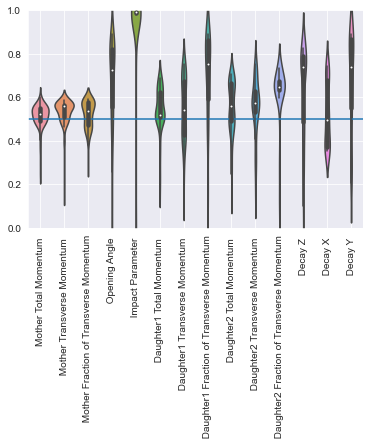

Background


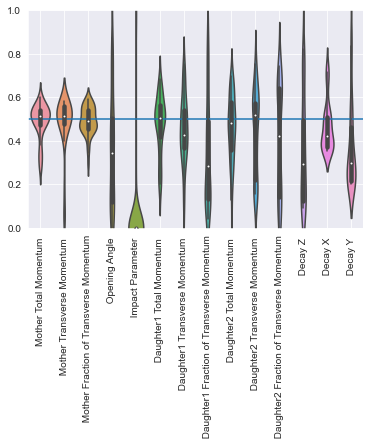

In [88]:

prob_sig = probabilities_boxplot(signal_data)

prob_bac = probabilities_boxplot(background_data)
plt.plot([-1, 14],[0.5,0.5])
# plt.show()
ay = sns.violinplot(data=prob_sig)
ay.set_xticklabels( [remove_units(name) for name in feature_names], rotation=90)

plt.grid(1)
plt.ylim((0,1))
print("Signal")
plt.show()

plt.plot([-1, 14],[0.5,0.5])
ax = sns.violinplot(data=prob_bac)
ax.set_xticklabels([remove_units(name) for name in feature_names], rotation=90)

plt.grid(1)
plt.ylim((0,1))
print("Background")
plt.show()

# Categorising from probabilities

Classifier model

Data preparation

-- probability_data

-- signal_id

In [98]:
feature_names = mf_signal.features
feature_size = len(feature_names)

signal_data_size = len(mf_signal.dev_data[feature_names[0]])
background_data_size =  len(mf_background.dev_data[feature_names[0]])
data_size = min(signal_data_size, background_data_size)

remaining_type = "background"
if signal_data_size > background_data_size:
    remaining_type = "signal"

# with this signal_select and background_select one can choose train and validation data

signal_select = np.random.choice(range(signal_data_size), 
                                 data_size, replace=False)
background_select = np.random.choice(range(background_data_size), 
                                     data_size, replace=False)

signal_traindata = {}
for feat in feature_names:
    signal_traindata[feat] = np.array([mf_signal.dev_data[feat].iat[i] for i in signal_select])

background_traindata = {}
for feat in feature_names:
    background_traindata[feat] = np.array([mf_background.dev_data[feat].iat[i] for i in background_select])


prob0 = {}
prob1 = {}

for k, feat in enumerate(feature_names):
    fi0 = mf_signal.distfit_array[feat].probability_array(background_traindata[feat])
    gi0 = mf_background.distfit_array[feat].probability_array(background_traindata[feat])

    prob0[feat] = fi0/(fi0+gi0) # precalculation of each feature probabilities 

    fi1 = mf_signal.distfit_array[feat].probability_array(signal_traindata[feat])
    gi1 = mf_background.distfit_array[feat].probability_array(signal_traindata[feat])

    prob1[feat] = fi1/(fi1+gi1)

data_shuffle = np.random.permutation(np.concatenate( (np.zeros(data_size), 
                                                      np.ones(data_size)) ))
probability_data = [] # x_train
signal_id = [] # y_train

test = []

prob0_indx = 0
prob1_indx = 0

for id in data_shuffle:
    if id==0:
        temp = []
        for feat in feature_names:
            temp.append(prob0[feat][prob0_indx])
        
        prob0_indx+=1
        if np.any(np.isnan(temp)):
            continue
        
        probability_data.append(np.array(temp))
        signal_id.append(np.array((0,)))
        
    else:
        temp = []
        for feat in feature_names:
            temp.append(prob1[feat][prob1_indx])
        
        prob1_indx+=1
        if np.any(np.isnan(temp)):
            continue
        
        probability_data.append(np.array(temp))
        signal_id.append(np.array((1,)))
        
### this is wrong, much lower data
# for i in range(data_size):
#     for j in [0, 1]:
#         if data_shuffle[2*i+j] == 0: # if background
#             temp = []
#             for feat in feature_names:
#                 temp.append(prob0[feat][i])

#             if np.any(np.isnan(temp)):
#                 continue
            
#             test.append((i,0))
#             probability_data.append(np.array(temp))
#             signal_id.append(np.array((0,)))
#         elif data_shuffle[2*i+j] == 1: # if signal
#             temp = []
#             for feat in feature_names:
#                 temp.append(prob1[feat][i])
            
#             if np.any(np.isnan(temp)):
#                 continue
#             test.append((i,1))
#             probability_data.append(np.array(temp))
#             signal_id.append(np.array((1,)))

assert not np.any(np.isnan(probability_data))
data_size = len(probability_data)
print("data_size: ",data_size)


# remaining = np.array([])
remain_traindata = {}
# remaining_data = []
# remaining_id = []

# print(remaining_type)
if remaining_type == "background":
    remaining_select = np.array(list(set(background_select).symmetric_difference(range(background_data_size))))
    
    for feat in feature_names:
        remain_traindata[feat] = np.array([mf_background.dev_data[feat].iat[i] for i in remaining_select])
    
elif remaining_type == "signal": 
    remaining_select = np.array(list(set(signal_select).symmetric_difference(range(signal_data_size))))
    
    for feat in feature_names:
        remain_traindata[feat] = np.array([mf_signal.dev_data[feat].iat[i] for i in remaining_select])

        
prob2 = {}
for k, feat in enumerate(feature_names):
    fi2 = mf_signal.distfit_array[feat].probability_array(remain_traindata[feat])
    gi2 = mf_background.distfit_array[feat].probability_array(remain_traindata[feat])
    
    prob2[feat] = fi2/(fi2+gi2)

x_remain = []
y_remain = []
for i in range(len(remaining_select)):
    temp = []
    for feat in feature_names:
        temp.append(prob2[feat][i])

    if np.any(np.isnan(temp)):
        continue

    x_remain.append(np.array(temp))
    if remaining_type=="signal":
        y_remain.append(np.array((1,)))
    else:
        y_remain.append(np.array((0,)))

x_remain = np.array(x_remain)
y_remain = np.array(y_remain)
print("remain_type: ",remaining_type,"; remain_size: ",len(x_remain))
print("decay: ", decay_analysis)

invalid value encountered in true_divide


data_size:  182


invalid value encountered in true_divide


remain_type:  signal ; remain_size:  3445
decay:  K mu


In [31]:
print(len(probability_data))
print(len(np.unique(probability_data)))
# print(probability_data)
# print(np.unique(probability_data))

1092
8526


In [30]:
np.unique([[1,1,2,3],[1,2,2,4]])

array([1, 2, 3, 4])

Preparing train and validation samples 

In [15]:
def intersect_data_array(arr1, arr2):
    set1 = set([tuple(val) for val in arr1])
    set2 = set([tuple(val) for val in arr2])
    
    return np.array([x for x in set1 & set2])


In [99]:
dev_shuffle, val_shuffle = train_test_split(range(data_size), test_size=0.25, random_state=80085)
# print(np.intersect1d(dev_shuffle, val_shuffle)) # making sure there is no intersection

x_train = np.array([probability_data[i] for i in dev_shuffle])
y_train = np.array([signal_id[i] for i in dev_shuffle])

x_val = np.array([probability_data[i] for i in val_shuffle])
y_val = np.array([signal_id[i] for i in val_shuffle])

print("Intersection of train with validation: ", len(intersect_data_array(x_train, x_val)))
print("Intersection of train/val with remain: ",len(intersect_data_array(np.concatenate((x_train, x_val)), x_remain)))

Intersection of train with validation:  0
Intersection of train/val with remain:  0


In [42]:
compileArgs = {'loss':'binary_crossentropy', 
          'optimizer':Adam(learning_rate=1.0e-4)}
trainParams = {'epochs' : 600,
            'batch_size' : 1, 
                'verbose' : 2}

Setting up the model classifier

In [258]:
os.getcwd()

'C:\\Users\\raulf\\Documents\\Neutralinos'

In [248]:
# os.chdir("C:\\Users\\raulf\\Documents\\Neutralinos\\Classification Network")


In [56]:
# os.chdir("C:\\Users\\raulf\\Documents\\Neutralinos\\Classification Network")


if not os.path.isdir("train_weights"):
    os.mkdir("train_weights")

savefile_name = "Classification Network/classification_best_weights/model1-{}.h5".format(decay_analysis)

model = None
model = getClassifier(feature_size, len(y_val[0]),"model0", compileArgs)

lossHistory = LossHistory((x_train, y_train))
earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
saveBest = ModelCheckpoint("Classification Network/train_weights/best.h5", monitor='val_loss', verbose=0, 
                            save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
histories = []
results = []


#saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, 
#                            save_best_only=True, save_weights_only=True, mode='auto', period=1)
   

In [92]:
decay_select['decay']

'K mu'

Fitting the data 

In [58]:

C = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
              callbacks=[earlyStop, saveBest, lossHistory], **trainParams)
histories.append(lossHistory.losses)
# model.load_weights("train_weights/best.h5")


Train on 1707 samples, validate on 569 samples
Epoch 1/600
1707/1707 - 4s - loss: 0.6594 - val_loss: 0.5265
Epoch 2/600
1707/1707 - 3s - loss: 0.4326 - val_loss: 0.3595
Epoch 3/600
1707/1707 - 3s - loss: 0.3476 - val_loss: 0.3211
Epoch 4/600
1707/1707 - 3s - loss: 0.3106 - val_loss: 0.2776
Epoch 5/600
1707/1707 - 3s - loss: 0.2679 - val_loss: 0.2671
Epoch 6/600
1707/1707 - 3s - loss: 0.2388 - val_loss: 0.2066
Epoch 7/600
1707/1707 - 3s - loss: 0.2146 - val_loss: 0.1670
Epoch 8/600
1707/1707 - 3s - loss: 0.1833 - val_loss: 0.1370
Epoch 9/600
1707/1707 - 3s - loss: 0.1513 - val_loss: 0.0895
Epoch 10/600
1707/1707 - 3s - loss: 0.1236 - val_loss: 0.0697
Epoch 11/600
1707/1707 - 3s - loss: 0.1095 - val_loss: 0.0811
Epoch 12/600
1707/1707 - 3s - loss: 0.1053 - val_loss: 0.0488
Epoch 13/600
1707/1707 - 3s - loss: 0.0845 - val_loss: 0.0583
Epoch 14/600
1707/1707 - 3s - loss: 0.0792 - val_loss: 0.0502
Epoch 15/600
1707/1707 - 3s - loss: 0.0775 - val_loss: 0.0408
Epoch 16/600
1707/1707 - 3s - lo

1707/1707 - 3s - loss: 0.0151 - val_loss: 0.0053
Epoch 133/600
1707/1707 - 3s - loss: 0.0087 - val_loss: 0.0048
Epoch 134/600
1707/1707 - 3s - loss: 0.0091 - val_loss: 0.0058
Epoch 135/600
1707/1707 - 3s - loss: 0.0115 - val_loss: 0.0050
Epoch 136/600
1707/1707 - 3s - loss: 0.0063 - val_loss: 0.0063
Epoch 137/600
1707/1707 - 3s - loss: 0.0158 - val_loss: 0.0058
Epoch 138/600
1707/1707 - 3s - loss: 0.0123 - val_loss: 0.0063
Epoch 139/600
1707/1707 - 3s - loss: 0.0089 - val_loss: 0.0039
Epoch 140/600
1707/1707 - 3s - loss: 0.0079 - val_loss: 0.0046
Epoch 141/600
1707/1707 - 3s - loss: 0.0087 - val_loss: 0.0067
Epoch 142/600
1707/1707 - 3s - loss: 0.0095 - val_loss: 0.0032
Epoch 143/600
1707/1707 - 3s - loss: 0.0088 - val_loss: 0.0178
Epoch 144/600
1707/1707 - 3s - loss: 0.0153 - val_loss: 0.0046
Epoch 145/600
1707/1707 - 3s - loss: 0.0066 - val_loss: 0.0036
Epoch 146/600
1707/1707 - 3s - loss: 0.0196 - val_loss: 0.0053
Epoch 147/600
1707/1707 - 3s - loss: 0.0147 - val_loss: 0.0097
Epoch 

Epoch 263/600
1707/1707 - 3s - loss: 0.0106 - val_loss: 0.0056
Epoch 264/600
1707/1707 - 3s - loss: 0.0027 - val_loss: 0.0057
Epoch 265/600
1707/1707 - 3s - loss: 0.0094 - val_loss: 0.0170
Epoch 266/600
1707/1707 - 3s - loss: 0.0081 - val_loss: 0.0045
Epoch 267/600
1707/1707 - 3s - loss: 0.0052 - val_loss: 0.0084
Epoch 268/600
1707/1707 - 3s - loss: 0.0044 - val_loss: 0.0045
Epoch 269/600
1707/1707 - 3s - loss: 0.0148 - val_loss: 0.0093
Epoch 270/600
1707/1707 - 3s - loss: 0.0116 - val_loss: 0.0735
Epoch 271/600
1707/1707 - 3s - loss: 0.0062 - val_loss: 0.0089
Epoch 272/600
1707/1707 - 3s - loss: 0.0083 - val_loss: 0.0929
Epoch 273/600
1707/1707 - 3s - loss: 0.0129 - val_loss: 0.0074
Epoch 274/600
1707/1707 - 3s - loss: 0.0039 - val_loss: 0.0064
Epoch 275/600
1707/1707 - 3s - loss: 0.0033 - val_loss: 0.0116
Epoch 276/600
1707/1707 - 3s - loss: 0.0114 - val_loss: 0.0017
Epoch 277/600
1707/1707 - 3s - loss: 0.0132 - val_loss: 0.0061
Epoch 278/600
1707/1707 - 3s - loss: 0.0046 - val_loss:

Epoch 393/600
1707/1707 - 3s - loss: 0.0065 - val_loss: 0.0120
Epoch 394/600
1707/1707 - 3s - loss: 0.0094 - val_loss: 0.0144
Epoch 395/600
1707/1707 - 3s - loss: 0.0035 - val_loss: 0.0194
Epoch 396/600
1707/1707 - 3s - loss: 0.0055 - val_loss: 0.0020
Epoch 397/600
1707/1707 - 3s - loss: 0.0066 - val_loss: 0.0095
Epoch 398/600
1707/1707 - 3s - loss: 0.0022 - val_loss: 0.0055
Epoch 399/600
1707/1707 - 3s - loss: 0.0183 - val_loss: 0.0060
Epoch 400/600
1707/1707 - 3s - loss: 0.0023 - val_loss: 0.0044
Epoch 401/600
1707/1707 - 3s - loss: 0.0050 - val_loss: 0.0182
Epoch 402/600
1707/1707 - 3s - loss: 0.0047 - val_loss: 0.0031
Epoch 403/600
1707/1707 - 3s - loss: 0.0027 - val_loss: 0.0061
Epoch 404/600
1707/1707 - 3s - loss: 0.0144 - val_loss: 0.0123
Epoch 405/600
1707/1707 - 3s - loss: 0.0062 - val_loss: 0.0072
Epoch 406/600
1707/1707 - 3s - loss: 0.0076 - val_loss: 0.0059
Epoch 407/600
1707/1707 - 3s - loss: 0.0048 - val_loss: 0.0039
Epoch 408/600
1707/1707 - 3s - loss: 0.0019 - val_loss:

Epoch 523/600
1707/1707 - 3s - loss: 0.0087 - val_loss: 0.0016
Epoch 524/600
1707/1707 - 5s - loss: 0.0034 - val_loss: 0.0098
Epoch 525/600
1707/1707 - 3s - loss: 0.0043 - val_loss: 0.0051
Epoch 526/600
1707/1707 - 3s - loss: 0.0014 - val_loss: 0.0040
Epoch 527/600
1707/1707 - 3s - loss: 0.0074 - val_loss: 0.0108
Epoch 528/600
1707/1707 - 3s - loss: 0.0036 - val_loss: 0.0013
Epoch 529/600
1707/1707 - 3s - loss: 0.0097 - val_loss: 0.0088
Epoch 530/600
1707/1707 - 3s - loss: 0.0018 - val_loss: 0.0105
Epoch 531/600
1707/1707 - 3s - loss: 0.0027 - val_loss: 0.0037
Epoch 532/600
1707/1707 - 3s - loss: 0.0054 - val_loss: 0.0042
Epoch 533/600
1707/1707 - 3s - loss: 0.0010 - val_loss: 0.0115
Epoch 534/600
1707/1707 - 3s - loss: 0.0150 - val_loss: 0.0039
Epoch 535/600
1707/1707 - 3s - loss: 0.0024 - val_loss: 0.0014
Epoch 536/600
1707/1707 - 3s - loss: 0.0013 - val_loss: 0.0139
Epoch 537/600
1707/1707 - 3s - loss: 0.0024 - val_loss: 0.0037
Epoch 538/600
1707/1707 - 3s - loss: 0.0080 - val_loss:

Getting the model with the best loss, by getting the one saved by ModelCheckpoint

In [59]:

results.append({})
model.load_weights("Classification Network/train_weights/best.h5")
results[-1]['loss'] = model.evaluate(x_train, y_train, verbose=0)
results[-1]['val_loss'] = model.evaluate(x_val, y_val, verbose=0)
# , validation_data = (x_val, y_val)

print("Score is: ", results[-1])


Score is:  {'loss': 0.013971509673464628, 'val_loss': 3.7337932163970604e-05}


In [89]:
decay_analysis

'K mu'

In [425]:
savefile_name = "Classification Network/classification_best_weights/model1-{}.h5".format(decay_select['decay'])

model.save(savefile_name)

Plotting the loss history

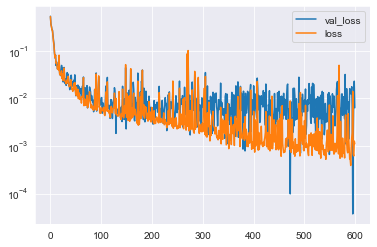

In [61]:

# ax = sns.lineplot(x=[range(100)[:],range(100)[:]],y=lossHistory.losses)
# plt.plot(lossHistory.losses['loss'])
# ay = 
# plt.show()
plt.plot(lossHistory.losses['val_loss'], label='val_loss')
plt.yscale("log")
plt.grid(True)
# plt.show()

plt.plot(lossHistory.losses['loss'], label='loss')
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

Model characteristics

In [100]:
# decay_analysis = decay_select['decay']
savefile_name = "Classification Network/classification_best_weights/model1-{}.h5".format(decay_select['decay'])

model = load_model(savefile_name)


In [101]:
pred_train = model.predict(x_train, verbose=0)
pred_val = model.predict(x_val, verbose=0)


dev_auc = roc_auc_score(y_train, pred_train)
val_auc = roc_auc_score(y_val, pred_val)

print("dev_auc: ", dev_auc)
print("val_auc: ", val_auc)

dev_auc:  1.0
val_auc:  1.0


In [144]:
print(np.sum(y_val - pred_val))
print(len(y_val))

0.00565592837451951
193


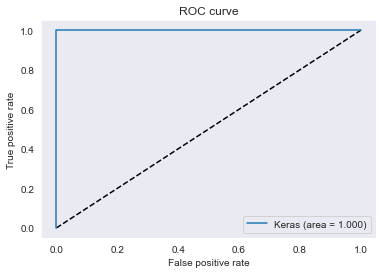

In [63]:
fpr, tpr, threshold = roc_curve(y_val, pred_val)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(val_auc))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [68]:
fp_threshold = 0.5
# fp_threshold = 0.9936
# fp_threshold = 0.941
# fp_threshold = 0.59
# fp_threshold = 0.98
# fp_threshold = 0.99924

fp1 = FalsePositives(thresholds=fp_threshold)
fp1.update_state(y_val[:,0], pred_val[:,0])

fp2 = FalsePositives(thresholds=fp_threshold)
fp2.update_state(y_train[:,0], pred_train[:,0])
print("False positives in val: ",fp1.result().numpy())
print("False positives in train: ", fp2.result().numpy())

False positives in val:  0.0
False positives in train:  0.0


In [94]:
fp_threshold = 0.5
# fp_threshold = 0.9936
# fp_threshold = 0.59
# fp_threshold = 0.98
# fp_threshold = 0.99924
# 
fn1 = FalseNegatives(fp_threshold)
fn1.update_state(y_val[:,0], pred_val[:,0])

fn2 = FalseNegatives(fp_threshold)
fn2.update_state(y_train[:,0], pred_train[:,0])
print("False negatives in val: ",fn1.result().numpy())
print("False negatives in train: ", fn2.result().numpy())

False negatives in val:  0.0
False negatives in train:  4.0


## Remain

In [93]:
pred_remain = model.predict(x_remain, verbose=0)
# print(np.sum(pred_remain-y_remain))
fp_threshold = 0.5
# fp_threshold = 0.941
# fp_threshold = 0.59
# fp_threshold = 0.99924

if remaining_type == "background":
    fp1 = FalsePositives(fp_threshold)
    fp1.update_state(y_remain[:,0], pred_remain[:,0])
    print("False positives in remain: ", fp1.result().numpy())
elif remaining_type == "signal":
    fp1 = FalseNegatives(fp_threshold)
    fp1.update_state(y_remain[:,0], pred_remain[:,0])
    print("False negatives in remain: ", fp1.result().numpy())

False negatives in remain:  9.0


# SHAP

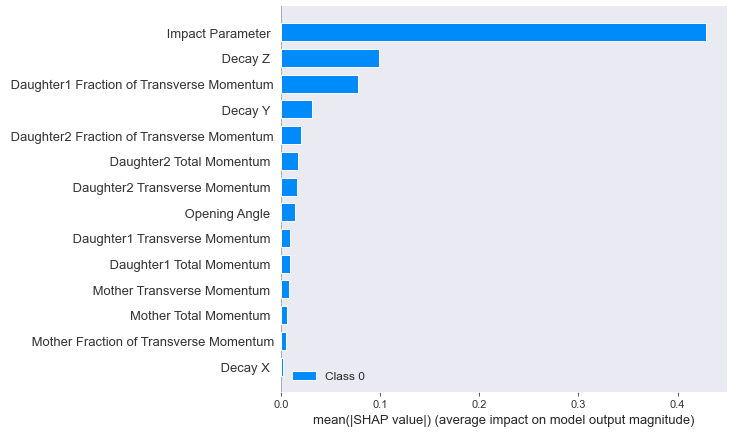

'K mu'

In [102]:

import shap
shap.initjs()
# explain predictions of the model on four images
# the X_class_train input needs to be a numpy array
e = shap.DeepExplainer(model, x_train)

# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_val)
x_val_df = pandas.DataFrame(x_val, columns=[remove_units(name) for name in feature_names])
shap.summary_plot(shap_values, x_val_df, plot_type="bar")
decay_analysis